In [ ]:
!pip install -q kaggle

In [ ]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)


In [ ]:
!gdown --id 1iVn4WhmZoq7lWgB1cPE6F8LzkQbf1dQ8

Downloading...
From: https://drive.google.com/uc?id=1iVn4WhmZoq7lWgB1cPE6F8LzkQbf1dQ8
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 134kB/s]


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c web-traffic-time-series-forecasting

 92% 63.0M/68.2M [00:00<00:00, 84.6MB/s]
100% 68.2M/68.2M [00:00<00:00, 108MB/s] 
 67% 44.0M/66.0M [00:00<00:00, 87.3MB/s]
100% 66.0M/66.0M [00:00<00:00, 134MB/s] 
 97% 146M/150M [00:00<00:00, 170MB/s]
100% 150M/150M [00:00<00:00, 193MB/s]
 90% 86.0M/96.0M [00:00<00:00, 115MB/s] 
100% 96.0M/96.0M [00:00<00:00, 178MB/s]
 83% 85.0M/102M [00:00<00:00, 84.5MB/s]
100% 102M/102M [00:01<00:00, 101MB/s]  
 93% 94.0M/101M [00:00<00:00, 148MB/s]
100% 101M/101M [00:00<00:00, 138MB/s] 


In [ ]:
!unzip train_2.csv.zip

Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [ ]:
!unzip key_2.csv.zip

Archive:  key_2.csv.zip
  inflating: key_2.csv               


<h3>Data Overview</h3>

The training dataset has a total of 145k time series for wikipedia pages and it conatins daily traffic on those pages from July 2015 to september 2017. We have to predict daily traffic on each of the pages from 13th september 2017 to 13th november 2017. We have given three files in total- train.csv,key.csv,sample_submission.csv.

Train.csv contains about 145k rows each of which represent a different wikipedia page and it has 804 columns, except the first column each column represent a date and it has daily traffic on that particular wikipedia page. First column contains the name of the page which includes the language of the wikipedia page(for example, for english en.wilipedia.org, for spanish es.wikipedia.org,zh,wikipedia.org for chinese),type of access(desktop,all access, agent(spider). For example one name is- 'AKB48_zh.wikipedia .org_all-access_spider’.

Second file is ‘key.csv’ which has number of rows equal to the number of predictions we have to make.There are two columns in this file- ‘page name’ and ‘id’. For each page name that is present in ‘train.csv’ file, we have 62 rows present in key.csv file, these 62 rows corresponds to 62 days of predictions for each page. For each page name there is corresponding id.

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tqdm.notebook import tnrange
import datetime
from scipy.fft import fft
import re

In [ ]:
train = pd.read_csv('train_2.csv')


In [ ]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [ ]:
key = pd.read_csv('key_2.csv')

<h2>Data Preprocessing</h2>

We used linear interpolation for filling missing values that were not missing for many consecutive days. Data which is missing for many consecutive days, maybe for months.Now, we can say that wherever there is a missing value, the page was not even created back then. So, we are filling those missing values with 0.

In [ ]:
train=train.interpolate(method ='linear',limit=1)
train = train.fillna(0)

In [ ]:
# saw during data analysis that usually peaks are present at regular intervals and there are very less number of peaks that are very large and occur only once or twice
# These peaks will not be useful for prediction, so replacing all these peaks with the median of the data
col=train.columns
for i in tnrange(train.shape[0]):
    k=train.iloc[i].values[1:]
    threshold=np.percentile(k,99.8)
    med=np.median(k)
    for j in col[1:]:
        if(train.at[i,j]>threshold):
            train.at[i,j]=med

<h2>Baseline Model</h2>

Will use median of data to make predictions, for each page we have taken median for each weekday and used it to make predictions for the next 62 days accordingly.


In [ ]:
week_day=[[[] for j in range(7)] for i in range(train.shape[0])]
for i in tqdm(train.columns[1:]):
    index=datetime.datetime.strptime(' '.join(i.split('-')), '%Y %m %d').weekday()
    for k in range(train.shape[0]):
        week_day[k][index].append(train.at[k,i])
        
for i in tnrange(len(week_day)):
    for j in range(7):
        week_day[i][j]=np.median(week_day[i][j])  

In [ ]:
!unzip sample_submission_2.csv.zip

Archive:  sample_submission_2.csv.zip
  inflating: sample_submission_2.csv  


In [ ]:
submit_file = pd.read_csv('sample_submission_2.csv')

In [ ]:
Page_name = train['Page'].values

In [ ]:
# Below code takes name of each page from train data which contains 145063*62 rows i.e. 62 names for each page
ids=key['Page'].values
visits={} 
# In this we will store our predictions, keys are the name of the page and values are the predictions
for i in tnrange(train.shape[0]):
    date = datetime.date(2017,9,13)
    for j in range(62):
        k=date.weekday()
        name =Page_name[i] + '_' + str(date)
        visits[name]=week_day[i][k]
        date += datetime.timedelta(days=1) #https://stackoverflow.com/questions/3240458/how-to-increment-a-datetime-by-one-day
# Below code maps each page name to the corresponding id for Kaggle submission
for i in tnrange(len(ids)):
    sub.at[i,'Visits']=visits[ids[i]]        

In [ ]:
submit_file.to_csv('median_submission.csv',index=False)

In [ ]:
!kaggle competitions submit -c web-traffic-time-series-forecasting -f median_submission.csv -m "Prediction done using median sub1"

Submission in Kaggle

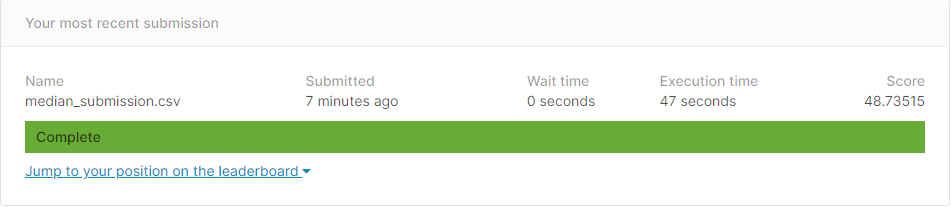

For this submission, we are currently at 310th position out of 1095 total teams

<h2>Feature Engineering</h2>

In [ ]:
week_day=[] # This list will contain 145063*15 values, each corresponding to the 
             # week day of every data point that we are creating

# All the list which contain 'temp' in their names are just temporary and will be used to generate main features.
temp_week=[]

l=len(train.columns)
for i in (train.columns[l-15:l]): # This loop will generate day of the week feature for 15 continuous days for one page.
    d=i.split('-')
    date=datetime.date(int(d[0]),int(d[1]),int(d[2]))
    temp_week.append(date.weekday())

# Now, these three feature will contain the total traffic on each page for last 3 bins of 3 days. 
threedays_1=[] # It will contain the total traffic for d-3 to d days
threedays_2=[] # It will contain the total traffic for d-6 to d-3 days
threedays_3=[] # It will contain the total traffic for d-9 to d-6 days

#As we saw during data analysis part that there is a high corelation for 7 days.
# So, we are creating a feature for that as well.
weekly_trend=[] # It will contain traffic on d-7 days

target_value=[]

# Below is the code that will generate all the features that we discussed above.
for j in tqdm(range(train.shape[0])):
    k=train.iloc[j].values

    weekly_temp=[]
    for i in range(788,803):
        weekly_temp.append(k[i-7])
    weekly_trend.extend(weekly_temp)  
  
    temp_list=[]
    temp_list1=[]
    temp_list2=[]
    for i in range(788,803):
        temp_list.append(k[i-1]+k[i-2]+k[i-3])
        temp_list1.append(k[i-4]+k[i-5]+k[i-6])
        temp_list2.append(k[i-7]+k[i-8]+k[i-9])
        target_value.append(k[i])
    threedays_1.extend(temp_list) 
    threedays_2.extend(temp_list1)
    threedays_3.extend(temp_list2) 
    week_day.extend(temp_week)

In [ ]:
# As we saw during analysis that there were some unneccessary peaks at the start,so after removing some initial values, we will take top 3 peaks and use them as features
# These 6 list will contain the X and Y co-ordinates for top 3 peaks
fourier_feat1_x=[]
fourier_feat2_x=[]
fourier_feat3_x=[]
fourier_feat1_y=[]
fourier_feat2_y=[]
fourier_feat3_y=[]
for t in tnrange(len(Page_name)):
    data=train.iloc[t][1:].values # This is the data that we are going to transform into the frequency domain
    data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
    x=fft(data) #Fourier Transformation
    freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
    y=2/803*np.abs(x[0:803//2]) # Taking absolute values of half data points 

  # Below is the code to create features from the frequency domain
    temp=y.copy()
    temp1=temp[15:]
    temp1=np.sort(temp1)
    k=temp1[len(temp1)-3:]
    fourier_temp1_x=[]
    fourier_temp2_x=[]
    fourier_temp3_x=[]
    fourier_temp1_y=[]
    fourier_temp2_y=[]
    fourier_temp3_y=[]
    for i in range(len(k)):
        temp_fourier_x=[]
        temp_fourier_y=[]
        temp_fourier_x.append(freq[list(y).index(k[i])])
        temp_fourier_y.append(list(y).index(k[i]))
        if(i==0):
            for j in range(15):
                fourier_temp1_x.extend(temp_fourier_x)
                fourier_temp1_y.extend(temp_fourier_y)
        if(i==1):
            for j in range(15):
                fourier_temp2_x.extend(temp_fourier_x)
                fourier_temp2_y.extend(temp_fourier_y)
        if(i==2):
            for j in range(15):
                fourier_temp3_x.extend(temp_fourier_x)
                fourier_temp3_y.extend(temp_fourier_y)
    fourier_feat1_x.extend(fourier_temp1_x) 
    fourier_feat2_x.extend(fourier_temp2_x) 
    fourier_feat3_x.extend(fourier_temp3_x)    
    fourier_feat1_y.extend(fourier_temp1_y) 
    fourier_feat2_y.extend(fourier_temp2_y) 
    fourier_feat3_y.extend(fourier_temp3_y)

In [ ]:
# As we know that language do we have an impact on traffic, so using language as a feature can be useful

def get_language(page): #this fuction extract the language from the page details
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language) #adding the new column as language

# creating features for last 15 days so every page will have 15 rows in data. So, appending the laguage of a page 15 times to the list
lang_feature =[]
for j in tqdm(range(train.shape[0])):
  k=train.iloc[j].values

  lang_feat =[]
  for i in range(15):
    lang_feat.append(k[-1])
  lang_feature.extend(lang_feat)

In [ ]:
# Extract the access and agent details from the page details and saving them in the new column
page_details = pd.DataFrame([i.split("_")[-2:] for i in train["Page"]])
page_details.columns = ["access", "agent"]
train = train.merge(page_details, how="inner", left_index=True, right_index=True)

In [ ]:
# We saw that type of access also has an impact on traffic, so we are creating a feature for that as well. 
access_feature =[]
for j in tqdm(range(train.shape[0])):
  k=train.iloc[j].values

  access_feat =[]
  for i in range(15):
    access_feat.append(k[-2])
  access_feature.extend(access_feat)

In [ ]:
# We saw that type of agent also has an impact on traffic, so we are creating a feature for that as well. 
agent_feature =[]
for j in tqdm(range(train.shape[0])):
  k=train.iloc[j].values

  agent_feat =[]
  for i in range(15):
    agent_feat.append(k[-1])
  agent_feature.extend(access_feat)

<h3>Summary and key take aways from our work till now.</h3>

First, we loaded the required libraries and files.
Handling Missing values :

We used linear interpolation for filling missing values that were not missing for many consecutive days. For filling consecutive missing values, we used the data from 180 days later.

Data Analysis:

1. Saw that most of the traffic was on English laguage pages.
3. There was very less traffic by bots as compared to actual human.
4. May has most number of visitors.
5. Weekdays and weekend doesn't actually make much difference.
6. Last three months of the year has more number of visitors on an average than other months of the year.
8. On average, English language has the most number of visitors.

<h2>Feature Engineering :</h2>

Used rolling window technique to generate features, from every time series we used 15 days of data. These are the features that we generated-
Day of the week
1. Number of visitors on d-7 days
2. Total visitors on last 3 buckets of 3 days.
3. Language of the page
4. Client of the page (All access, mobile,desktop)
5. Spider or actual human traffic
6. Top three peaks from fourier transformed data.

<h3>Making data model ready</h3>

In [ ]:
# Now, will start to build model based on the features that we have created
# Firstly will convert all the categorical features into one hot encoded features
from sklearn.preprocessing import OneHotEncoder,normalize
enc_access_feat = OneHotEncoder(sparse=False)
access_feat_ohe=enc_access_feat.fit_transform(np.array(access_feature).reshape(-1,1))

enc_week_day = OneHotEncoder(sparse=False)
week_day_ohe=enc_week_day.fit_transform(np.array(week_day).reshape(-1,1))

enc_lang_feat = OneHotEncoder(sparse=False)
lang_feat_ohe=enc_lang_feat.fit_transform(np.array(lang_feature).reshape(-1,1))

enc_spider_feat = OneHotEncoder(sparse=False)
spider_feat_ohe=enc_spider_feat.fit_transform(np.array(agent_feature).reshape(-1,1))



In [ ]:
# Will start with linear regression, so now have to normalise the numerical features
weekly_trend=normalize(np.array(weekly_trend).reshape(-1,1),axis=0)
threedays_1=normalize(np.array(threedays_1).reshape(-1,1),axis=0)
threedays_2=normalize(np.array(threedays_2).reshape(-1,1),axis=0)
threedays_3=normalize(np.array(threedays_3).reshape(-1,1),axis=0)
fourier_feat1_x=normalize(np.array(fourier_feat1_x).reshape(-1,1),axis=0)
fourier_feat2_x=normalize(np.array(fourier_feat2_x).reshape(-1,1),axis=0)
fourier_feat3_x=normalize(np.array(fourier_feat3_x).reshape(-1,1),axis=0)
fourier_feat1_y=normalize(np.array(fourier_feat1_y).reshape(-1,1),axis=0)
fourier_feat2_y=normalize(np.array(fourier_feat2_y).reshape(-1,1),axis=0)
fourier_feat3_y=normalize(np.array(fourier_feat3_y).reshape(-1,1),axis=0)

target_value=np.array(target_value).reshape(-1,1) # This is our target value

# Here creating numpy arrays for our dataset
# As the dataset is quite big( about 2 Million data points), will keep our data in numpy arrays for faster operations
data=np.column_stack((week_day_ohe,weekly_trend,threedays_1,threedays_2,threedays_3,lang_feat_ohe,spider_feat_ohe,access_feat_ohe,\
               fourier_feat1_x,fourier_feat2_x,fourier_feat3_x,fourier_feat1_y,fourier_feat2_y,fourier_feat3_y))

In [ ]:
indices = np.random.permutation(data.shape[0]) # Shuffling the indexes of our data
training_idx, test_idx = indices[:int(0.75*data.shape[0])], indices[int(0.75*data.shape[0]):] # Taking 70% of data for training
x_train,x_test = data[training_idx,:], data[test_idx,:]
y_train,y_test=target_value[training_idx,:],target_value[test_idx,:]

y_train=y_train.reshape(y_train.shape[0])
y_test=y_test.reshape(y_test.shape[0])

<h3>Modelling</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from operator import sub,truediv,add
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

<h3>Performance Metric</h3>

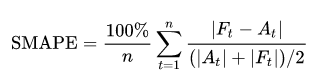


where At is the actual value and Ft is the forecast value. Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors.
In contrast to the mean absolute percentage error, SMAPE has both a lower bound and an upper bound. Indeed, the formula above provides a result between 0% and 200%.

In [ ]:
# This will be our performance metric, this is custom build SMAPE 
def smape(actual,visits):
    temp_list=[2 for i in range(len(actual))]
    val1=np.abs(list(map(sub,visits,actual)))
    val2=list(map(add,np.abs(actual),np.abs(visits)))
    val4=list(map(truediv,val2,temp_list))
    val3=[]
    for i in range(len(val4)):
        if(val4[i]==0):
            val3.append(0)
        else:    
            val3.append(val1[i]/val4[i])
    return(np.sum(val3)/len(val3))  

<h4>Linear Regression</h4>

In [ ]:
reg = LinearRegression()
reg.fit(x_train,y_train)
pred=reg.predict(x_test)
score=smape(y_test,pred)
print('smape on LinearRegression is: ',score)

smape on LinearRegression is:  0.7981847374271297


These are not good results, we should try more powerful alogorithm and see how these performs.

<h3>Decision Tree</h3>

In [ ]:
# Let's try decision tree, will do hyperparameter tuning as well
max_depth=[10,50,500,1000]
min_samples_split=[2,5,10,50,100,500]
reg= DecisionTreeRegressor()
random_grid={'max_depth':max_depth,'min_samples_split':min_samples_split}
dt_grid = GridSearchCV(estimator = reg,scoring=make_scorer(smape,greater_is_better=False), param_grid = random_grid, \
                                cv = 3, verbose=30,iid=True, n_jobs = -1)
dt_grid.fit(x_train, y_train)

In [ ]:
dt_grid.best_params_ # These are the beat hyperparameters

{'max_depth': 1000, 'min_samples_split': 10}

In [ ]:
# Decision tree with best hyperparameters

reg= DecisionTreeRegressor(random_state=0,max_depth=1000,min_samples_split=10)
reg.fit(x_train,y_train)
pred=reg.predict(x_test)
score=smape(y_test,pred)
print('smape on DT with best hyperparameter is: ',score)

smape on DT with best hyperparameter is:  0.40971058500263513


Results are good in comparision to Linear Regression but overall these does not seem capable of getting us in good position on leaderboard.

<h3>Random Forest</h3>

In [ ]:
# Will try Random Forest, this shoud get us better results
# Will start with hyperparameter tuning

reg= RandomForestRegressor(random_state=0,max_depth=1000,min_samples_split=10)
n_estimators=[50,100,250]
random_grid={'n_estimators':n_estimators}
rf_random = GridSearchCV(estimator = reg,scoring=make_scorer(smape,greater_is_better=False), param_grid = random_grid, \
                                cv = 3, verbose=20,n_jobs = -1)
rf_random.fit(x_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
# Random forest with best hyperparameters
reg= RandomForestRegressor(random_state=0,max_depth=1000,min_samples_split=10,n_estimators=250)
reg.fit(x_train,y_train)
pred=reg.predict(x_test)
score=smape(y_test,pred)

In [ ]:
score

0.37255756015019287

These results are far better than Decision tree but keep in mind that we are using certain features for this prediction that we don't have future data and we have to make prediction sequentially in order to make predictions and use these predictions as a feature for future predictions, the errors in our predictions will increase exponentially as we will try to predict for more farther dates. So, we have to get much better score here from the score that we expecting on leaderboard because leaderboard score will greater than this. 

<h3>XGBoost</h3>

In [ ]:
# Will check how well Xgboost can perform
# Already tuned some of the hyperparameters in RandomForest and will use those here as well because tuning them again will take a lot of time
random_grid={'learning_rate':[0.01,0.1,1]}
reg=XGBRegressor(max_depth=1000,verbosity=3,n_jobs=-1,n_estimators=250)
xgb_grid = GridSearchCV(estimator = reg,scoring=make_scorer(smape,greater_is_better=False), param_grid = random_grid, \
                                cv = 3, verbose=20,n_jobs = -1)
xgb_grid.fit(x_train, y_train)

In [ ]:
xgb_grid.best_params_

In [ ]:
# Xgboost training on best hyperparameters on new data

reg=XGBRegressor(max_depth=1000,n_jobs=-1,n_estimators=250,learning_rate=1)
reg.fit(x_train,y_train)
pred=reg.predict(x_test)
score_xgb=smape(y_test,pred)

[06:52:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
score_xgb

0.4389810987384087

The score is even more then the random forest and Decision tree algorithms

<h3>Summary of performane of all the models</h3>

Liner Regression- 0.79

Decision Tree- 0.40

Random Forest- 0.37

XgBoost - 0.43

Best performing model here is Random Forest, so we will use it for predctions for kaggle and lets hope this can perform good on leaderboard as well.

<h3>Predictions for kaggle</h3>

Will create all the features for predictions that we created during feature engineering

In [ ]:
backup = train
train = train.drop(['Page','lang','access','agent'],axis=1)

In [ ]:
# These 6 list will contain the X and Y co-ordinates for top 3 peaks
fourier_fea1_x=[]
fourier_fea2_x=[]
fourier_fea3_x=[]
fourier_fea1_y=[]
fourier_fea2_y=[]
fourier_fea3_y=[]
for t in tnrange(len(Page_name)):
    data=train.iloc[t].values # This is the data that we are going to transform into the frequency domain
    data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
    x=fft(data) #Fourier Transformation
    freq=np.linspace(0,803//2,803//2) # According to Shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
    y=2/803*np.abs(x[0:803//2]) # Taking absolute values of half data points 

  # Below is the code to create features from the frequency domain
    temp=y.copy()
    temp1=temp[15:]
    temp1=np.sort(temp1)
    k=temp1[len(temp1)-3:]
    fourier_temp1_x=[]
    fourier_temp2_x=[]
    fourier_temp3_x=[]
    fourier_temp1_y=[]
    fourier_temp2_y=[]
    fourier_temp3_y=[]
    for i in range(len(k)):
        temp_fourier_x=[]
        temp_fourier_y=[]
        temp_fourier_x.append(freq[list(y).index(k[i])])
        temp_fourier_y.append(list(y).index(k[i]))
        if(i==0):
            fourier_fea1_x.extend(temp_fourier_x)
            fourier_fea1_y.extend(temp_fourier_y)
        if(i==1):
            fourier_fea2_x.extend(temp_fourier_x)
            fourier_fea2_y.extend(temp_fourier_y)
        if(i==2):
            fourier_fea3_x.extend(temp_fourier_x)
            fourier_fea3_y.extend(temp_fourier_y)

Created all the features. Now, will combine all the features and start making predictions for kaggle.

In [ ]:
date=datetime.date(2017,9,11)
for m in tnrange(64):
    d=date.weekday()
    week_f=enc_week_day.transform(np.array([d]).reshape(-1,1))
    threedays_1=[]
    threedays_2=[]
    threedays_3=[]
    fourier1_x=[]
    fourier2_x=[]
    fourier3_x=[]
    fourier1_y=[]
    fourier2_y=[]
    fourier3_y=[]
    week_trend=[]
    lang=[]
    spider=[]
    access=[]
    week_f2=[]
    for i in range(train.shape[0]):
        k=train.iloc[i].values
        threedays_1.append(k[-1] + k[-2] + k[-3])
        threedays_2.append(k[-4] + k[-5] + k[-6])
        threedays_3.append(k[-7] + k[-8] + k[-9])
        fourier1_x.append(fourier_fea1_x[i])
        fourier2_x.append(fourier_fea2_x[i])
        fourier3_x.append(fourier_fea3_x[i])
        fourier1_y.append(fourier_fea1_y[i])
        fourier2_y.append(fourier_fea2_y[i])
        fourier3_y.append(fourier_fea3_y[i])
        week_trend.append(k[-7])
        lang.append(lang_feat_ohe[i])
        spider.append(spider_feat_ohe[i])
        access.append(access_feat_ohe[i])
        week_f2.append(week_f[0])
    pred_data=np.column_stack((week_f2,week_trend,threedays_1,threedays_2,threedays_3,lang,spider,access,fourier1_x,fourier2_x,
                           fourier3_x,fourier1_y,fourier2_y,fourier3_y))    
    pred_value=reg.predict(pred_data)
    train[str(date)]=pred_value # This will update the data so that we can take values from it in order to make predictions for farther dates.
    date += datetime.timedelta(days=1)   #https://stackoverflow.com/questions/3240458/how-to-increment-a-datetime-by-one-day

Now, done with all the predictions. Will prepare the submission file.

In [ ]:
# Below code takes name of each page from train data which contains 145063*62 rows i.e. 62 names for each page
ids=key['Page'].values
visits={} # In this we will store our predictions, keys are the name of the page and values are the predictions
for i in tnrange(train.shape[0]):
    date = datetime.date(2017,9,13)
    for j in range(62):
        name=Page_name[i] + '_' + str(date)
        visits[name]=train.at[i,str(date)]
        date += datetime.timedelta(days=1)   

In [ ]:
# Below code maps each page name to the corresponding id for Kaggle submission
for i in tnrange(len(ids)):
    submit_file.at[i,'Visits']=visits[ids[i]]

In [ ]:
submit_file.to_csv('rf_submission.csv',index=False)

In [ ]:
!kaggle competitions submit -c web-traffic-time-series-forecasting -f rf_submission.csv -m "Prediction done after feature engineering rf"

100% 189M/189M [00:06<00:00, 29.2MB/s]
Successfully submitted to Web Traffic Time Series Forecasting

Tried submitting with Xgboost algorithm, inspite of maximum score then random forest , xgb preformed well than random forest in Kaggle

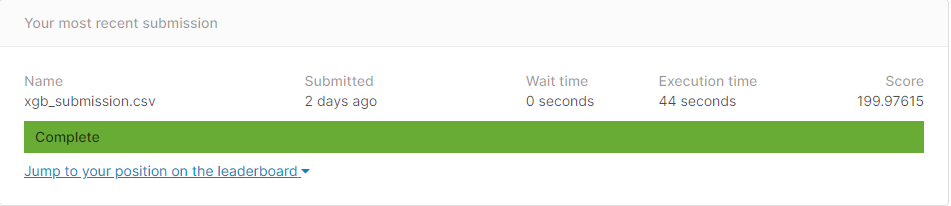


This is exactly what i was fearing, error indeed increased exponentially as we predicted for more farther dates, this score is worse than our median submission. Now, we have to think of something else.

Now, Will try LSTM as well. Like before, will not use any feature that uses predicted data as it will create problems.

<h3>LSTM</h3>

In [ ]:
backup =train
train = train.drop('Page',axis=1)

In [ ]:
indices = np.random.permutation(train.shape[0]) # Shuffling indexes of data
# As we have more than 145k time series, using only 50% of data to train the model.
idx=indices[:int(0.50*train.shape[0])]

For evaluating our model, will use Mean Absolute Error(MAE) on log1p of data. This is pretty similar to SMAPE on original data. After final predictions will use expm1 on data to convert it back to original form.

In [ ]:
#Along with the time series, will use the three features as well that can extract from the page name
x_train=[]
y_train=[]
lang=[] # This will contain the language of the page
agent=[] # this will contain if the page was accessed by spider or by actual human
access=[] #This will contain the client that was used to access the page
import re
for i in tqdm(idx):
    k=np.log1p(train.iloc[i].values[-264:]) # Taking last 264 days of data and converting it to log1p.
    x_train.append(k[:200]) # We will use 200 days of data for training and rest 64 days as our target values.
    y_train.append(k[200:])

    index=Page_name[i].find('.wikipedia')
    lang.append(Page_name[i][index-1:index-3:-1][::-1])

    if('spider' in Page_name[i]):
        agent.append('spider')
    else:
        agent.append('non-spider') 
 
    k=max([i.start() for i in re.finditer('org_',Page_name[i])])   #https://www.geeksforgeeks.org/python-all-occurrences-of-substring-in-string/
    if('all-access' in Page_name[i][k:]):
        access.append('all_access')
    if('desktop' in Page_name[i][k:]):
        access.append('desktop')
    if('mobile' in Page_name[i][k:]): 
        access.append('mobile')

In [ ]:
# Reshaping the data in order to fed it to the model
x=np.array(x_train).reshape(len(idx),200,1)
y=np.array(y_train).reshape(len(idx),64)

In [ ]:
x.shape

(72531, 200, 1)

In [ ]:
# As we have a total of 72531 data points, will use 50000 for training
x_train=x[:50000]
y_train=y[:50000]
x_test=x[50000:]
y_test=y[50000:]

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Label encoding each of the categorical feature
access_enc=LabelEncoder()
access=access_enc.fit_transform(access)

lang_enc=LabelEncoder()
lang=lang_enc.fit_transform(lang)

spider_enc=LabelEncoder()
spider=spider_enc.fit_transform(agent)

In [ ]:
access_train=access[:50000] # Splitting into train and test
access_test=access[50000:]

lang_train=lang[:50000]
lang_test=lang[50000:]

spider_train=spider[:50000]
spider_test=spider[50000:]

In [ ]:
# Reshaping
access_train=access_train.reshape(len(access_train),1)
access_test=access_test.reshape(len(access_test),1)
lang_train=lang_train.reshape(len(lang_train),1)
lang_test=lang_test.reshape(len(lang_test),1)
spider_train=spider_train.reshape(len(spider_train),1)
spider_test=spider_test.reshape(len(spider_test),1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Activation,LSTM,RepeatVector,TimeDistributed,Flatten,Conv1D,Conv2D,Embedding,Concatenate,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#model structure
input_layer=Input(shape=(x_train.shape[1],x_train.shape[2]))
x=LSTM(100)(input_layer)
input_layer1=Input(shape=(access_train.shape[1],))
x1=Embedding(input_dim=3,output_dim=3)(input_layer1)
x1=Flatten()(x1)
input_layer2=Input(shape=(lang_train.shape[1],))
x2=Embedding(input_dim=8,output_dim=8)(input_layer2)
x2=Flatten()(x2)
input_layer3=Input(shape=(spider_train.shape[1],))
x3=Embedding(input_dim=2,output_dim=2)(input_layer3)
x3=Flatten()(x3)
concat=Concatenate()([x,x1,x2,x3])
x=Dense(264,activation='relu')(concat)
x=Dense(128,activation='relu')(x)

output=Dense(64)(x)
model=Model(inputs=[input_layer,input_layer1,input_layer2,input_layer3],outputs=output)
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mae')
model.fit([x_train,access_train,lang_train,spider_train], y_train, validation_data=([x_test,access_test,lang_test,spider_test],y_test),epochs=80, batch_size=64)

Epoch 1/80
782/782 [==============================] - 18s 14ms/step - loss: 0.8879 - val_loss: 0.4070
Epoch 2/80
782/782 [==============================] - 11s 14ms/step - loss: 0.4013 - val_loss: 0.4045
Epoch 3/80
782/782 [==============================] - 10s 13ms/step - loss: 0.3942 - val_loss: 0.3848
Epoch 4/80
782/782 [==============================] - 10s 13ms/step - loss: 0.3830 - val_loss: 0.3746
Epoch 5/80
782/782 [==============================] - 10s 13ms/step - loss: 0.3768 - val_loss: 0.3654
Epoch 6/80
782/782 [==============================] - 10s 13ms/step - loss: 0.3720 - val_loss: 0.3726
Epoch 7/80
782/782 [==============================] - 10s 13ms/step - loss: 0.3656 - val_loss: 0.3635
Epoch 8/80
782/782 [==============================] - 10s 13ms/step - loss: 0.3637 - val_loss: 0.3579
Epoch 9/80
782/782 [==============================] - 10s 13ms/step - loss: 0.3626 - val_loss: 0.3587
Epoch 10/80
782/782 [==============================] - 10s 13ms/step - loss: 0.359

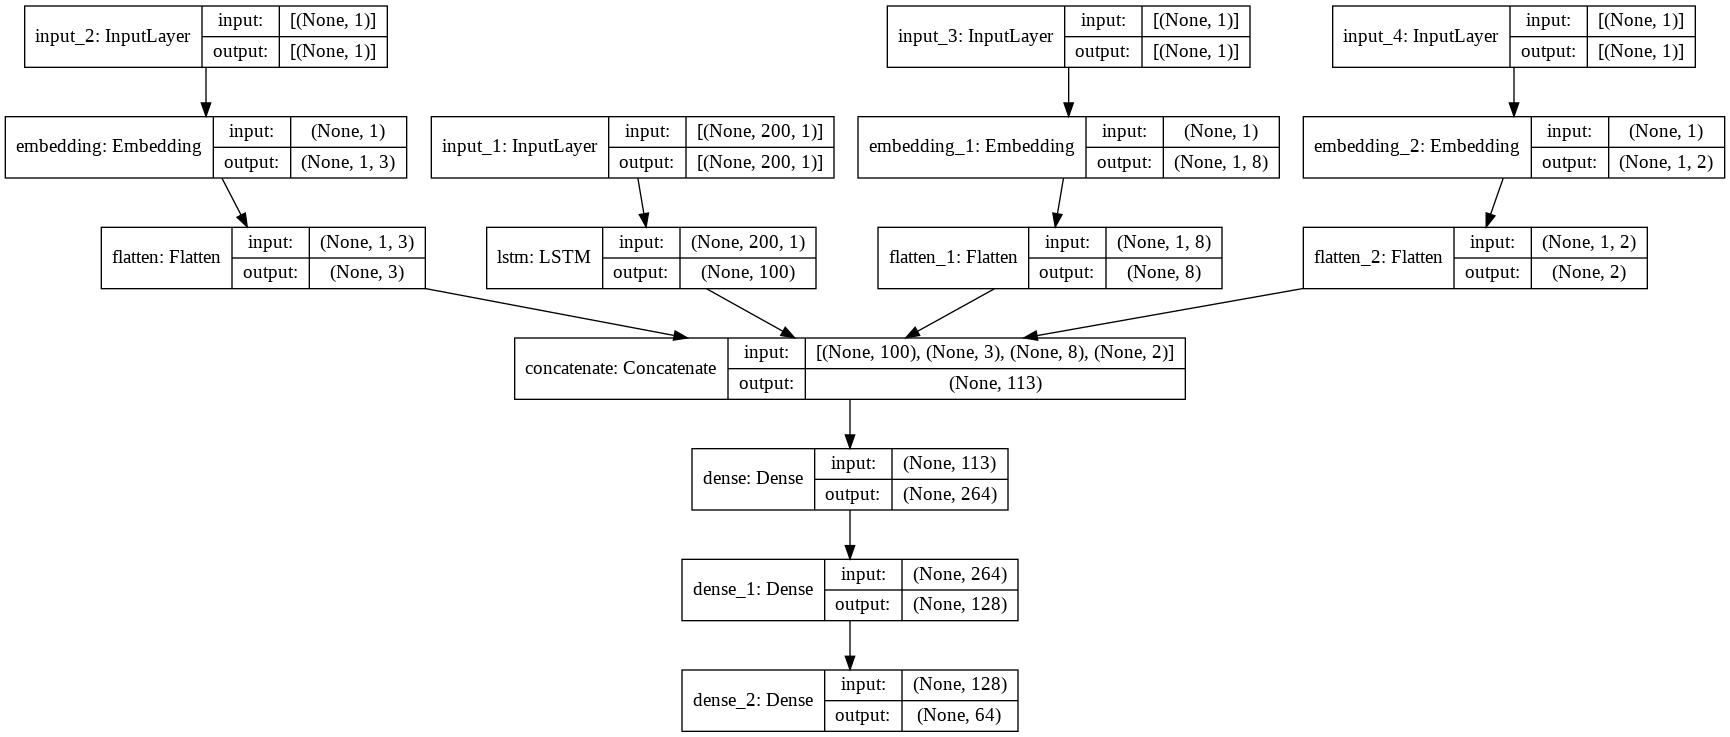

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
#model structure with Conv1D
input_layer=Input(shape=(x_train.shape[1],x_train.shape[2]))
cov1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x=LSTM(100)(cov1)
input_layer1=Input(shape=(access_train.shape[1],))
x1=Embedding(input_dim=3,output_dim=3)(input_layer1)
x1=Flatten()(x1)
input_layer2=Input(shape=(lang_train.shape[1],))
x2=Embedding(input_dim=8,output_dim=8)(input_layer2)
x2=Flatten()(x2)
input_layer3=Input(shape=(spider_train.shape[1],))
x3=Embedding(input_dim=2,output_dim=2)(input_layer3)
x3=Flatten()(x3)
concat=Concatenate()([x,x1,x2,x3])
x=Dense(264,activation='relu')(concat)
x=Dense(128,activation='relu')(x)

output=Dense(64)(x)
model=Model(inputs=[input_layer,input_layer1,input_layer2,input_layer3],outputs=output)
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mae')
filepath='/content/model_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5'
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True,mode='min')
callback = [model_checkpoint]
model.fit([x_train,access_train,lang_train,spider_train], y_train, validation_data=([x_test,access_test,lang_test,spider_test],y_test),epochs=100, batch_size=64,callbacks=callback)

Epoch 1/100
782/782 [==============================] - 15s 16ms/step - loss: 0.8967 - val_loss: 0.6932

Epoch 00001: val_loss improved from inf to 0.69317, saving model to /content/model_save/weights-01-0.6932.hdf5
Epoch 2/100
782/782 [==============================] - 12s 15ms/step - loss: 0.4264 - val_loss: 0.7767

Epoch 00002: val_loss did not improve from 0.69317
Epoch 3/100
782/782 [==============================] - 12s 15ms/step - loss: 0.4125 - val_loss: 0.7372

Epoch 00003: val_loss did not improve from 0.69317
Epoch 4/100
782/782 [==============================] - 12s 16ms/step - loss: 0.4032 - val_loss: 0.6409

Epoch 00004: val_loss improved from 0.69317 to 0.64087, saving model to /content/model_save/weights-04-0.6409.hdf5
Epoch 5/100
782/782 [==============================] - 12s 15ms/step - loss: 0.3949 - val_loss: 0.6321

Epoch 00005: val_loss improved from 0.64087 to 0.63214, saving model to /content/model_save/weights-05-0.6321.hdf5
Epoch 6/100
782/782 [================

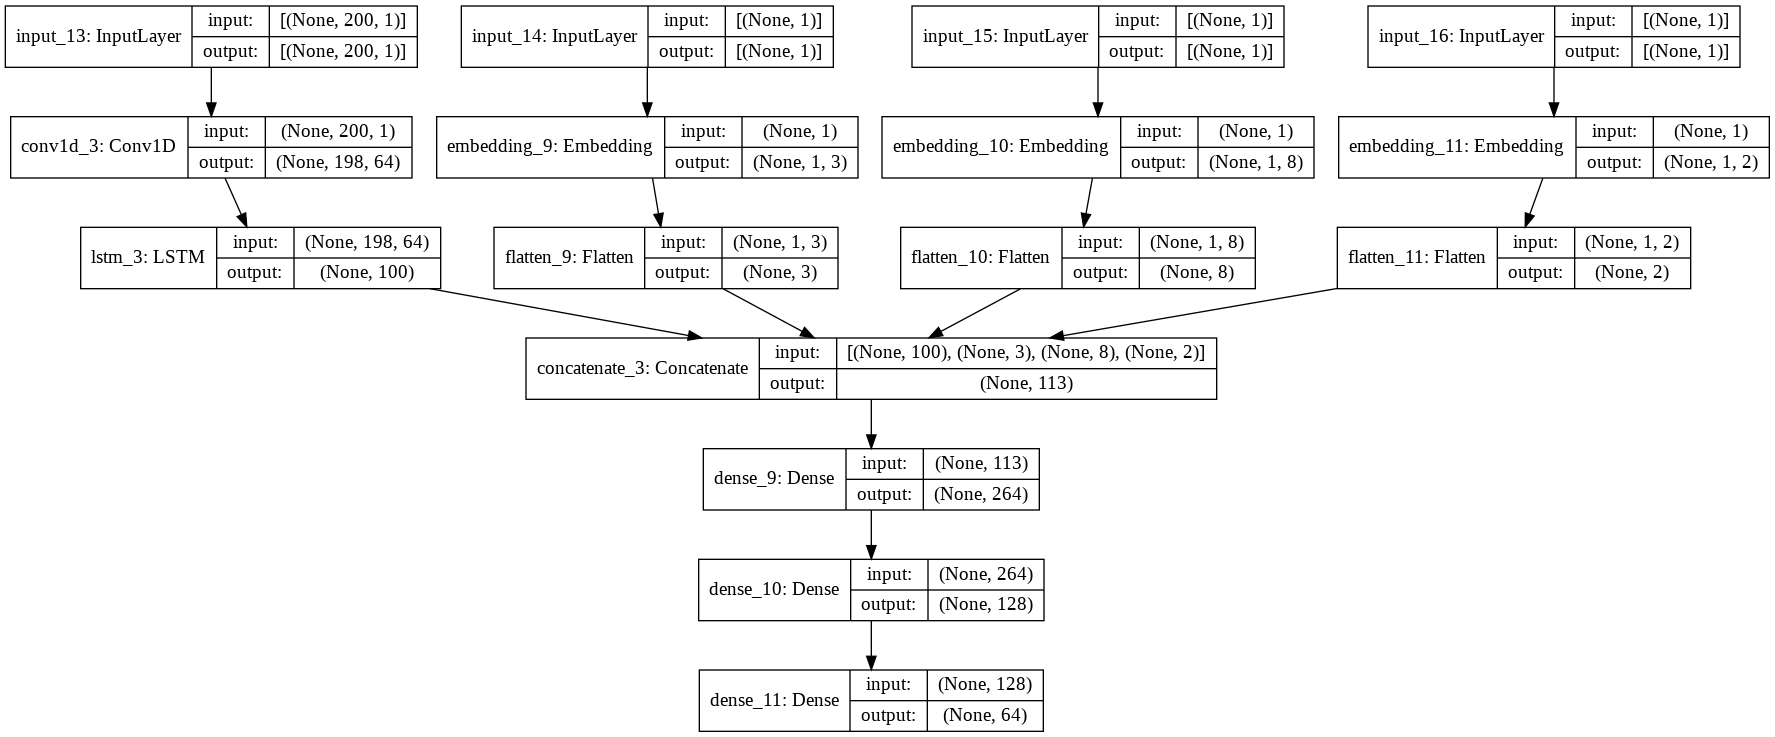

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Now, will prepare our data to make predictions for Kaggle.
x_pred=[]
lang_pred=[]
access_pred=[]
agent_pred=[]
for i in tnrange(train.shape[0]):
    k=np.log1p(train.iloc[i].values[-200:])
    x_pred.append(k)
    index=Page_name[i].find('.wikipedia')
    lang_pred.append(Page_name[i][index-1:index-3:-1][::-1])

    if('spider' in Page_name[i]):
        agent_pred.append('spider')
    else:
        agent_pred.append('non-spider') 
 
    k=max([i.start() for i in re.finditer('org_',Page_name[i])])   #https://www.geeksforgeeks.org/python-all-occurrences-of-substring-in-string/
    if('all-access' in Page_name[i][k:]):
        access_pred.append('all_access')
    if('desktop' in Page_name[i][k:]):
        access_pred.append('desktop')
    if('mobile' in Page_name[i][k:]): 
        access_pred.append('mobile')
x_pred=np.array(x_pred).reshape(train.shape[0],200,1)
lang_pred=lang_enc.transform(lang_pred).reshape(len(lang_pred),1)
access_pred=access_enc.transform(access_pred).reshape(len(access_pred),1)
spider_pred=spider_enc.transform(agent_pred).reshape(len(agent_pred),1)   
pred=model.predict([x_pred,access_pred,lang_pred,spider_pred])


In [ ]:
#Converting data to original form
for i in tnrange(pred.shape[0]):
    pred[i]=np.expm1(pred[i])

In [ ]:
# Below code takes name of each page from train data which contains 145063*62 rows i.e. 62 names for each page
ids=key['Page'].values
visits={} # In this we will store our predictions, keys are the name of the page and values are the predictions
for i in tnrange(train.shape[0]):
    date = datetime.date(2017,9,13)
    for j in range(62):
        name=Page_name[i] + '_' + str(date)
        visits[name]=pred[i][j+2]
        date += datetime.timedelta(days=1)  

In [ ]:
# Below code maps each page name to the corresponding id for Kaggle submission
for i in tnrange(len(ids)):
    submit_file.at[i,'Visits']=visits[ids[i]]

In [ ]:
submit_file.head()

,Id,Visits
0,0b293039387a,423
1,7114389dd824,408
2,057b02ff1f09,412
3,bd2aca21caa3,398
4,c0effb42cdd5,456


In [ ]:
submit_file.to_csv('kaggle_lstm4.csv',index=False)

In [ ]:
!kaggle competitions submit -c web-traffic-time-series-forecasting -f kaggle_lstm4.csv -m "Prediction done after feature engineering lstm,conv1d"

100% 140M/140M [00:01<00:00, 80.6MB/s]
Successfully submitted to Web Traffic Time Series Forecasting

<h3>Submission with only LSTM</h3>

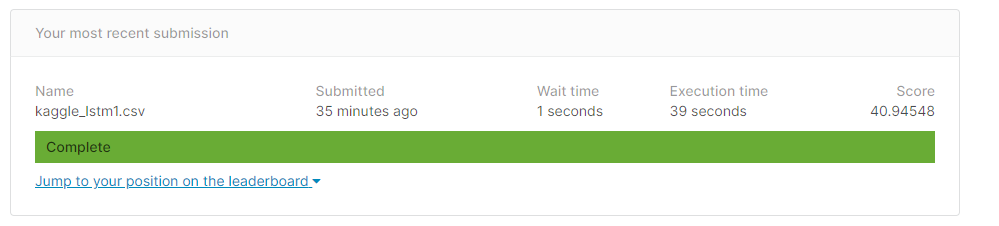

The score is good and it takes us in top 10% on leaderboard and 92/1095 position.

Submission with LSTM and Conv1D

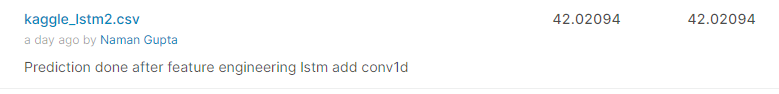

Tried to add Conv1d layer to improve the accuracy but seems that kaggle score increased. Also added some more layers of LSTM but still the score was increased. It might possoble due to overfitting of the model to overcome this added the dropout layer but it will not affect much on score still the score was not decreased further.  

Comparitive study of all the models that tried

In [2]:
from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Sno.","Model", "Kaggle Score"])
x.add_row([1,'Median Model',48.73])
x.add_row([2,'Decision Tree',199.98])
x.add_row([3,'Random Forest',199.978])
x.add_row([4,'XgBoost',199.976])
x.add_row([5,'LSTM',40.94])
x.add_row([6,'LSTM+conv1d',42.02])
x.add_row([7,'LSTM+conv1d+dropout',42.44])

print(x)

+------+---------------------+--------------+
| Sno. |        Model        | Kaggle Score |
+------+---------------------+--------------+
|  1   |     Median Model    |    48.73     |
|  2   |    Decision Tree    |    199.98    |
|  3   |    Random Forest    |   199.978    |
|  4   |       XgBoost       |   199.976    |
|  5   |         LSTM        |    40.94     |
|  6   |     LSTM+conv1d     |    42.02     |
|  7   | LSTM+conv1d+dropout |    42.44     |
+------+---------------------+--------------+


Tree based model was unable to perform good, their scores were worse than median model but LSTM proved to be a good choice maybe the reason is that they are specialised in seq-seq prediction.